# EDA - Full Dataset
## Team 8

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
from pyspark.sql.functions import isnull, when, count
from pyspark.sql.functions import *
from pyspark.sql import SQLContext
from pyspark.sql import functions as f
from pyspark.sql.types import *
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import pyspark

def spark_shape(self):
  """Hack to emulate pandas' df.shape"""
  return (self.count(), len(self.columns))

  
pyspark.sql.dataframe.DataFrame.shape = spark_shape

In [0]:
# Inspect the path for final project
display(dbutils.fs.ls("/mnt/mids-w261/datasets_final_project"))

path,name,size
dbfs:/mnt/mids-w261/datasets_final_project/airlines/,airlines/,0
dbfs:/mnt/mids-w261/datasets_final_project/airlines_data/,airlines_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/,parquet_airlines_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_3m/,parquet_airlines_data_3m/,0
dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data_6m/,parquet_airlines_data_6m/,0
dbfs:/mnt/mids-w261/datasets_final_project/stations_data/,stations_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data/,weather_data/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data_6_hr/,weather_data_6_hr/,0
dbfs:/mnt/mids-w261/datasets_final_project/weather_data_single/,weather_data_single/,0


## Azure Blob Storage (Read/Write)

In [0]:
from pyspark.sql.functions import col, max

blob_container = "w261team8rocks" # The name of your container created in https://portal.azure.com
storage_account = "dataguru" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261-team8" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "cloudblob" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://w261team8rocks@dataguru.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

# SAS Token
spark.conf.set(
  f"fs.azure.sas.w261team8rocks.dataguru.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

## Dataset Sources
Note: Path for full data in parenthesis. See schema link below.
#### 1. Airline dataset (dbfs:/mnt/mids-w261/datasets_final_project/parquet_airlines_data/)
https://www.transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ&flf_gnoyr_anzr=g_bagVZR_eRcbegVaT&h5r4_gnoyr_anzr=er2146v0t%20Pn44vr4%20b0-gvzr%20cr4s14zn0pr%20(EMLK-24r5r06)&lrn4_V0s1=E&Sv456_lrn4=EMLK&Yn56_lrn4=FDFE&en6r_V0s1=D&S4r37r0pB=Z106uyB&Qn6n_S4r37r0pB=N007ny,d7n46r4yB,Z106uyB

#### 2. Weather dataset (dbfs:/mnt/mids-w261/datasets_final_project/weather_data/)
* Simplified schema: https://docs.google.com/spreadsheets/d/1v0P34NlQKrvXGCACKDeqgxpDwmj3HxaleUiTrY7VRn0/edit#gid=0
* Full PDF schema: https://www.ncei.noaa.gov/data/global-hourly/doc/isd-format-document.pdf

#### 3. Station dataset (dbfs:/mnt/mids-w261/datasets_final_project/stations_data/)

# Airline Dataset EDA
Date Range: 2015-01-01 to 2019-12-31

In order to understand the dataset and choose what features to keep and drop for our final joined dataset, we run a high-level EDA (Exploratory Data Analysis) on both the airlines dataset and weather dataset. We plot some graphs to visualize feature distributions and identify relevant features for feature engineering.

In [0]:
# Flight table
# Load All Flights data (2015 - 2019)
df_airlines = spark.read.parquet("/mnt/mids-w261/datasets_final_project/parquet_airlines_data/*")

In [0]:
# Check for flight data duplicates
"""
Total record is 63,493,682. It seems every record is duplicated because 63,493,682 / 2 = 31,746,841.
"""
print("Total records count without dropping duplicates:", df_airlines.count())

df_airlines = df_airlines.dropDuplicates()

print("Total records count after dropping duplicates:", df_airlines.count())

Total records count without dropping duplicates: 63493682
Total records count after dropping duplicates: 31746841

### 1. High-level overview

After performing the preliminary analysis, we found the raw airlines dataset contains a total records count of 63,493,682 rows. However, it seems the raw airlines dataset has duplicated records and the total records count after dropping duplicates is 31,746,841. Several key properties of the dataset are listed below:

|Property|Data|
|-----------|----|
|Total flight count| 31,746,841|
|Total flight count delayed by more than 15 minutes| 5,693,541|
|% flights delayed | 17.93%|
|% flights on-time| 80.56%|
|% flights cancelled| 1.50%|
|Earliest flight date | 2015-01-01|
|Latest flight date|2019-12-31|
|Number of columns/features|107|
|Number of Unique Carriers|19|
|Number of Unique Airports|371|

In [0]:
# Summary of flight data
display(df_airlines.describe())

summary,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DELAY_NEW,DEP_DEL15,DEP_DELAY_GROUP,DEP_TIME_BLK,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,ARR_DELAY_NEW,ARR_DEL15,ARR_DELAY_GROUP,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,FIRST_DEP_TIME,TOTAL_ADD_GTIME,LONGEST_ADD_GTIME,DIV_AIRPORT_LANDINGS,DIV_REACHED_DEST,DIV_ACTUAL_ELAPSED_TIME,DIV_ARR_DELAY,DIV_DISTANCE,DIV1_AIRPORT,DIV1_AIRPORT_ID,DIV1_AIRPORT_SEQ_ID,DIV1_WHEELS_ON,DIV1_TOTAL_GTIME,DIV1_LONGEST_GTIME,DIV1_WHEELS_OFF,DIV1_TAIL_NUM,DIV2_AIRPORT,DIV2_AIRPORT_ID,DIV2_AIRPORT_SEQ_ID,DIV2_WHEELS_ON,DIV2_TOTAL_GTIME,DIV2_LONGEST_GTIME,DIV2_WHEELS_OFF,DIV2_TAIL_NUM,DIV3_AIRPORT,DIV3_AIRPORT_ID,DIV3_AIRPORT_SEQ_ID,DIV3_WHEELS_ON,DIV3_TOTAL_GTIME,DIV3_LONGEST_GTIME,DIV3_WHEELS_OFF,DIV3_TAIL_NUM,DIV4_AIRPORT,DIV4_AIRPORT_ID,DIV4_AIRPORT_SEQ_ID,DIV4_WHEELS_ON,DIV4_TOTAL_GTIME,DIV4_LONGEST_GTIME,DIV4_WHEELS_OFF,DIV4_TAIL_NUM,DIV5_AIRPORT,DIV5_AIRPORT_ID,DIV5_AIRPORT_SEQ_ID,DIV5_WHEELS_ON,DIV5_TOTAL_GTIME,DIV5_LONGEST_GTIME,DIV5_WHEELS_OFF,DIV5_TAIL_NUM
count,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31674354,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31746841,31274521,31269545,31269545,31269545,31269545,31746841,31260424,31260429,31244917,31244917,31746841,31244919,31176201,31176201,31176201,31176201,31746841,31746841,489947,31746841,31746677,31178799,31178799,31746841,31746841,31746841,5799114,5799114,5799114,5799114,5799114,203262,203260,203260,31746838,78108,66118,66119,78096,81641,81641,81641,81640,81641,81641,66537,66539,687,691,691,687,687,687,277,277,7,7,7,7,7,7,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
mean,2017.1512498204152,2.5174877084620797,6.552106365480585,15.749554640727876,3.9346285509162944,null,null,19949.20515190787,null,8806.54128440367,2339.5700956514065,12668.724409461716,1266875.803290192,31729.315288031336,null,null,null,26.35374732245013,null,54.91906164774001,12668.666651116562,1266870.0274082704,31729.2951808339,null,null,null,26.354102948384693,null,54.919218135750896,1330.0884999550035,1334.2122192375064,9.855285614165476,12.909587811399238,0.18207943223989986,0.036036885090588944,null,16.830789563186986,1356.9563268309594,1464.4766360877195,7.5604571777227,1488.9034405659447,1468.8957719173475,4.615475952313754,12.966188215170925,0.18601095752494026,-0.20968071125792395,null,0.015432937091284137,null,0.0024603392822611864,143.2167191860742,138.22906985609035,113.8502422431345,1.0,823.2170183483768,3.7652922065537164,19.98459350859459,3.2259498606166392,15.44036813209742,0.08916793151505557,25.364284785572416,1330.4193110369868,37.360331595001476,36.78451244711207,0.003480000118436992,0.8465074000102423,381.64725188299707,234.13669293243998,42.599236836713786,null,12717.885204737815,1271791.6214034616,1509.759015188633,35.31460908122145,28.555541945836037,1540.3529164224417,8805.0,null,12468.658465991317,1246869.2836468886,1384.3318777292577,22.676855895196507,18.86754002911208,1367.2454873646209,null,null,13244.285714285714,1324431.4285714286,1475.2857142857142,15.857142857142858,13.428571428571429,853.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
stddev,1.4316532810216036,1.1053295681781925,3.39943025614153,8.774238088354515,1.991763538747176,null,null,383.1919615319507,null,1.

In [0]:
# Number of Unique Airline Carriers
display(df_airlines.select("OP_UNIQUE_CARRIER").distinct())
print("Total Number of Unique Airpline Carriers:", df_airlines.select("OP_UNIQUE_CARRIER").distinct().count())

OP_UNIQUE_CARRIER
UA
NK
AA
EV
B6
DL
OO
F9
YV
US


Total Number of Unique Airpline Carriers: 19

In [0]:
# Number of Unique Airports
# display(df_airlines.select("ORIGIN").distinct())
print("Total Number of Unique Airports:", df_airlines.select("ORIGIN").distinct().count())

Total Number of Unique Airports: 371

### 2. Cancelled Flights

In approximately 1.5% of records in the flights dataset the outcome feature `DEP_DEL15` is null, meaning these are cancelled flights. Our EDA analysis indicated that flights are cancelled due to the following reasons: "Carrier", "Weather", "National Air System", "Security". We take out these cancelled flights from the dataset since they are null for the feature we are trying to predict (`DEP_DEL15`), and are therefore not relevant, and also minimal in number.

In [0]:
# About 18% of flights departed with delays. We will have to deal with class imbalance in the modeling process later.
# About 1.5% of flights don't have labels on delays (These are cancelled flights).
total_flight = df_airlines.count()
delayed_flight = df_airlines.filter(df_airlines.DEP_DEL15 == 1).cache()
on_time_flight = df_airlines.filter(df_airlines.DEP_DEL15 == 0).cache()
cancelled_flight = df_airlines.filter(df_airlines.DEP_DEL15.isNull()).cache()
print(f'Total Flight: {total_flight}')
print(f'Total Flight delayed by more than 15 minutes: {delayed_flight.count()}')
print(f'Delayed Flight: {delayed_flight.count() / total_flight }')
print(f'On Time Flight: {on_time_flight.count() / total_flight}')
print(f'Cancelled Flight: {cancelled_flight.count() / total_flight}')

Total Flight: 31746841
Total Flight delayed by more than 15 minutes: 5693541
Delayed Flight: 0.17934196980417674
On Time Flight: 0.8056235894462697
Cancelled Flight: 0.015034440749553632

### 3. Class Imbalance for Departure Delays

The total number of flights delayed by more than 15 minutes is 5,693,541, which is about 17.9% of the total number of flights, and the total proportion of on-time flights is 80.6%. This shows a class imbalance which could lead to a prediciton bias towards the "on time flight", since our model algorithms tend to behave in favor of the majority class to acheive high accuracy.

We also observed results from our initial baseline model using a three-month toy sample of the dataset that produced a low recall and F-1 score, which is caused by many false negatives (when the model predicts the flight is not delayed, but it is actually delayed). Therefore, for future steps, we plan to account for the class imbalance by utilizing a balancing ratio in a weight column with the class weight option. 

The figure below shows the `DEP_DELAY_GROUP` field which groups delay times by 15 minute intervals. As expected, the Departure Delay Group distribution is skewed to the right since the majority of flights are delayed less than 15 minutes.

As expected, the Departure delay group distribution is skewed to the right since the majority of flights are delayed less than 15 minutes.

Out[46]:

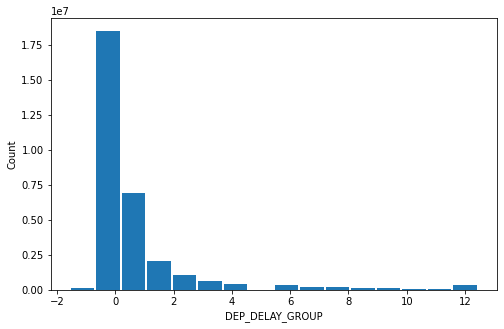

Text(0, 0.5, 'Count')

In [0]:
# The DEP_DELAY_GROUP field groups contain delay times by 15 minutes intervals.
# Take a look at the distribution - buckets 2 and above are the outcome, i.e. flights delayed 15m or more:
n_buckets = len(df_airlines.select("DEP_DELAY_GROUP").distinct().collect())
hist = df_airlines.select("DEP_DELAY_GROUP").rdd.flatMap(lambda x: x).histogram(n_buckets)
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x=hist[0][1:], height=hist[1])
ax.set_xlabel('DEP_DELAY_GROUP')
ax.set_ylabel('Count')


### 4. Time-related Factors

Intuitively we suspect that flight delays are strongly impacted by seasonality and time-related factors. Therefore we further explored a few time features in relation to the flight departure delays and plot histogram graphs of the distributions, and observe the following patterns:

* (1) Hour of Day: the number of departure delays generally increases rapidly in the afternoon and peaks between 4 - 7 pm.
* (2) Day of Week: Thursday and Friday have slightly more delays in a week.
* (3) Day of Month: close to uniform distribution.
* (4) Quarter: close to uniform distribution with slightly more delays in Q2 and Q3.
* (5) Month of Year: June to August and December have more delays in a year. This might relate to seasonality and holiday travel which we can consider for feature engineering.

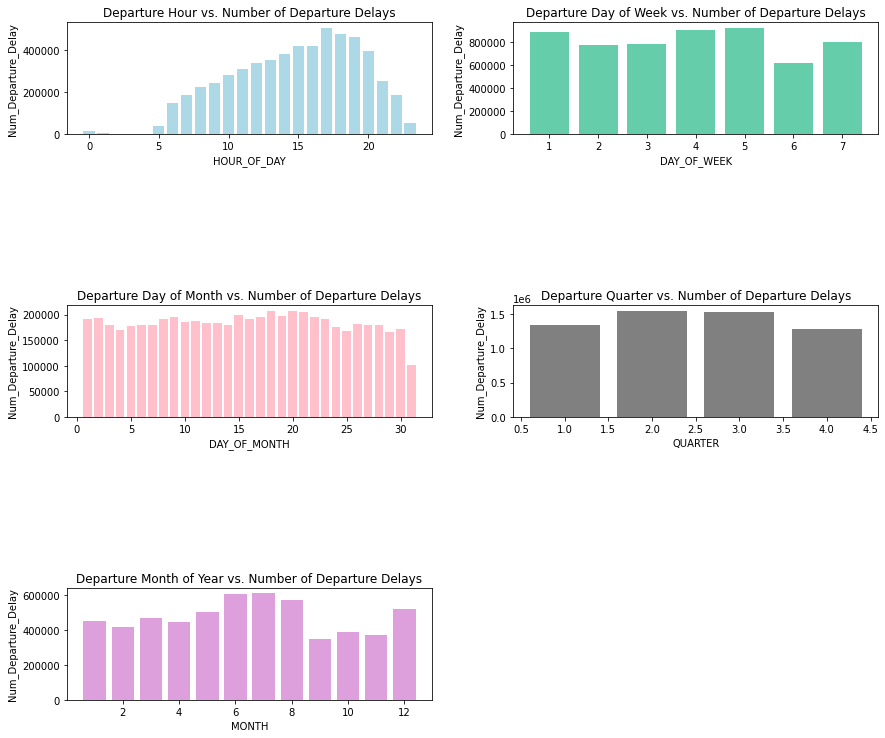

In [0]:
fig, ax = plt.subplots(3,2, figsize = (12, 10))
fig.tight_layout(h_pad=15, w_pad=5) 

ax[0][0].bar(data_hour['HOUR_OF_DAY'] , data_hour['Num_Departure_Delay'],  
            label='Num_Departure_Delay', color = 'lightblue' )
ax[0][0].set_xlabel('HOUR_OF_DAY')
ax[0][0].set_ylabel('Num_Departure_Delay')
ax[0][0].set_title('Departure Hour vs. Number of Departure Delays')

ax[0][1].bar(day_of_week_del['DAY_OF_WEEK'] , day_of_week_del['Num_Departure_Delay'],  
            label='Num_Departure_Delay', color = 'mediumaquamarine')
ax[0][1].set_xlabel('DAY_OF_WEEK')
ax[0][1].set_ylabel('Num_Departure_Delay')
ax[0][1].set_title('Departure Day of Week vs. Number of Departure Delays')

ax[1][0].bar(day_of_month_del['DAY_OF_MONTH'] , day_of_month_del['Num_Departure_Delay'],  
            label='Num_Departure_Delay', color = 'pink')
ax[1][0].set_xlabel('DAY_OF_MONTH')
ax[1][0].set_ylabel('Num_Departure_Delay')
ax[1][0].set_title('Departure Day of Month vs. Number of Departure Delays')

ax[1][1].bar(quarter_del['QUARTER'] , quarter_del['Num_Departure_Delay'],  
            label='Num_Departure_Delay', color = 'grey' )
ax[1][1].set_xlabel('QUARTER')
ax[1][1].set_ylabel('Num_Departure_Delay')
ax[1][1].set_title('Departure Quarter vs. Number of Departure Delays')

ax[2][0].bar(month_del['MONTH'] , month_del['Num_Departure_Delay'],  
            label='Num_Departure_Delay', color = 'plum')
ax[2][0].set_xlabel('MONTH')
ax[2][0].set_ylabel('Num_Departure_Delay')
ax[2][0].set_title('Departure Month of Year vs. Number of Departure Delays')


ax[2][1].set_axis_off()

To get a more holistic sense of the seasonality of the data, we look at the daily average delay rate of flights over the whole dataset. We calculated the percent of flights delayed on each day, and then calculated the average for each day of the year, over all years (ignoring February 29th so the dates all line up). Below is this daily average plotted over the 5 years. Two things stand out which are important for feature engineering and selection:

* (1) While there significant day to day variance, there is also a strong seasonal component, shown clearly by the blue and green rolling averages below. In general there seem to be more delayed flights in the middle of the year (probably when lots of people are traveling in summer for vacations), and around the beginning/end of the year, probably for vacation travels around the Christmas/New Year break. 
* (2) There are specific holiday dates which have very specific delay characteristics across the years. July 4th and December 25th are marked by vertical dotted lines in the below plot, and we see very clearly that on those dates there is a very low delay rate, because not many people are traveling, and either side of the holidays there are peaks in delay rates, because lots of people are traveling.

In [0]:
date_flight_count = df_airlines.groupby("ORIGIN").pivot("FL_DATE").count().toPandas()
date_delay_count = df_airlines.groupby("ORIGIN").pivot("FL_DATE").sum("DEP_DEL15").toPandas()
date_flight_count = date_flight_count.set_index("ORIGIN")
date_delay_count = date_delay_count.set_index("ORIGIN")
date_delay_rate = (date_delay_count.sum() / date_flight_count.sum()).sort_index()

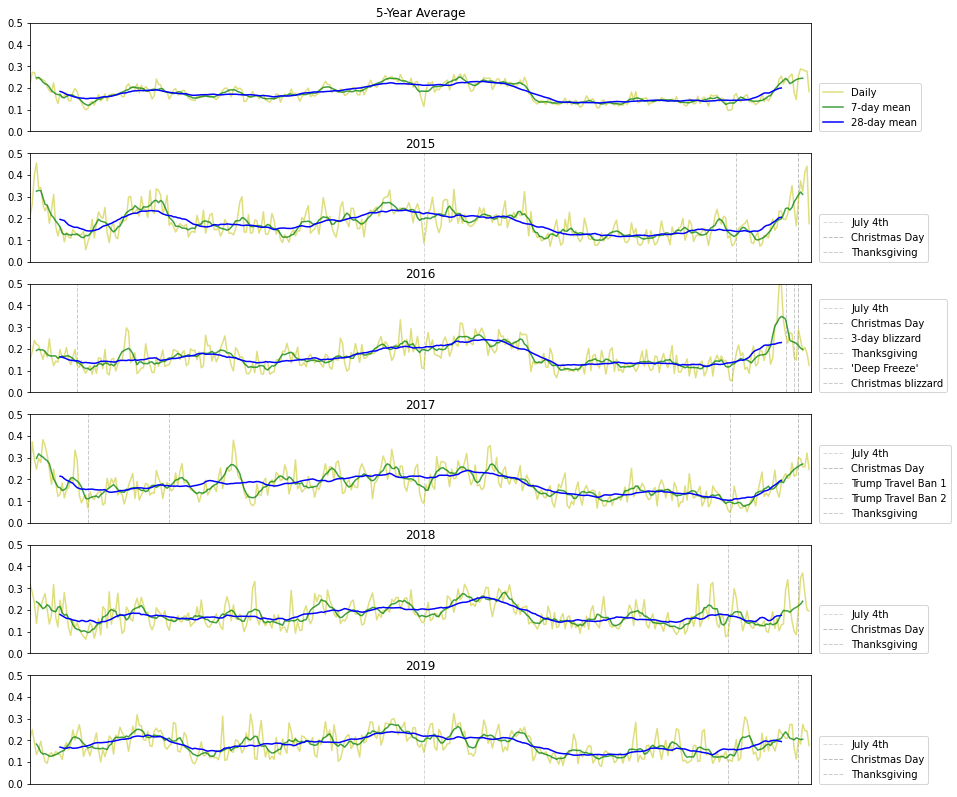

In [0]:
delay_date_by_year = dict()
for year in range(2015, 2020, 1):
  delay_date_by_year[year] = date_delay_rate[
    (date_delay_rate.index >= f"{year}-01-01") & 
    (date_delay_rate.index < f"{year+1}-01-01")
  ]
# Average Feb 28/29 and remove 29 date in leap year to make plots line up:
dr_2016 = delay_date_by_year[2016]
feb_28_29 = (dr_2016.loc["2016-02-28"] + dr_2016.loc["2016-02-29"]) / 2
dr_2016.loc["2016-02-28"] = feb_28_29
dr_2016 = dr_2016[dr_2016.index != "2016-02-29"]
delay_date_by_year[2016] = dr_2016
[len(v) for v in delay_date_by_year.values()]

# Date markers:
date_markers = {
  2015: {
    "Thanksgiving": 330,
  },
  2016: {
    "3-day blizzard": 22,
    "Thanksgiving": 328,
    "'Deep Freeze'": 353,
    "Christmas blizzard": 357,
  },
  2017: {
    "Trump Travel Ban 1": 27,
    "Trump Travel Ban 2": 65,
    "Thanksgiving": 327,
  },
  2018: {
    "Thanksgiving": 326,
  },
  2019: {
    "Thanksgiving": 326,
  },
}

# Create the plots:
fig, axes = plt.subplots(nrows=len(delay_date_by_year) + 1, figsize=(14, 14))

# Plot averages first:
mu = pd.Series(np.mean([v.values for v in delay_date_by_year.values()], axis=0))
ax = axes[0]
ax.set_title("5-Year Average")
ax.plot(mu.values, label="Daily", alpha=0.5, color="y")
rolling_week = mu.rolling(7, center=True).mean()
ax.plot(rolling_week, label="7-day mean", alpha=0.75, color="g")
rolling_week = mu.rolling(28, center=True).mean()
ax.plot(rolling_week, label="28-day mean", alpha=1, color="b")

ax.legend(loc=(1.01, 0))
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_ylim(0, 0.5)
ax.set_xlim(0, 365)

# Plot individual years:
for i, (year, data) in enumerate(delay_date_by_year.items()):
  ax = axes[i+1]
  ax.set_title(f"{year}")
  ax.plot(data.values, alpha=0.5, color="y")
  rolling_week = data.rolling(7, center=True).mean()
  ax.plot(rolling_week, alpha=0.75, color="g")
  rolling_week = data.rolling(28, center=True).mean()
  ax.plot(rolling_week, alpha=1, color="b")
  ax.vlines(184, 0, 0.5, label="July 4th", color="#b3b3b3", 
            linestyle="--", lw=1, alpha=0.5)
  ax.vlines(359, 0, 0.5, label="Christmas Day", 
            color="#808080", linestyle="--", lw=1, alpha=0.5)
  
  for k, v in date_markers[year].items():
    ax.vlines(v, 0, 0.5, label=k, color="#999999", linestyle="--", lw=1, alpha=0.5)

  ax.legend(loc=(1.01, 0))
  ax.set_xticklabels([])
  ax.set_xticks([])
  ax.set_ylim(0, 0.5)
  ax.set_xlim(0, 365)

Out[107]:

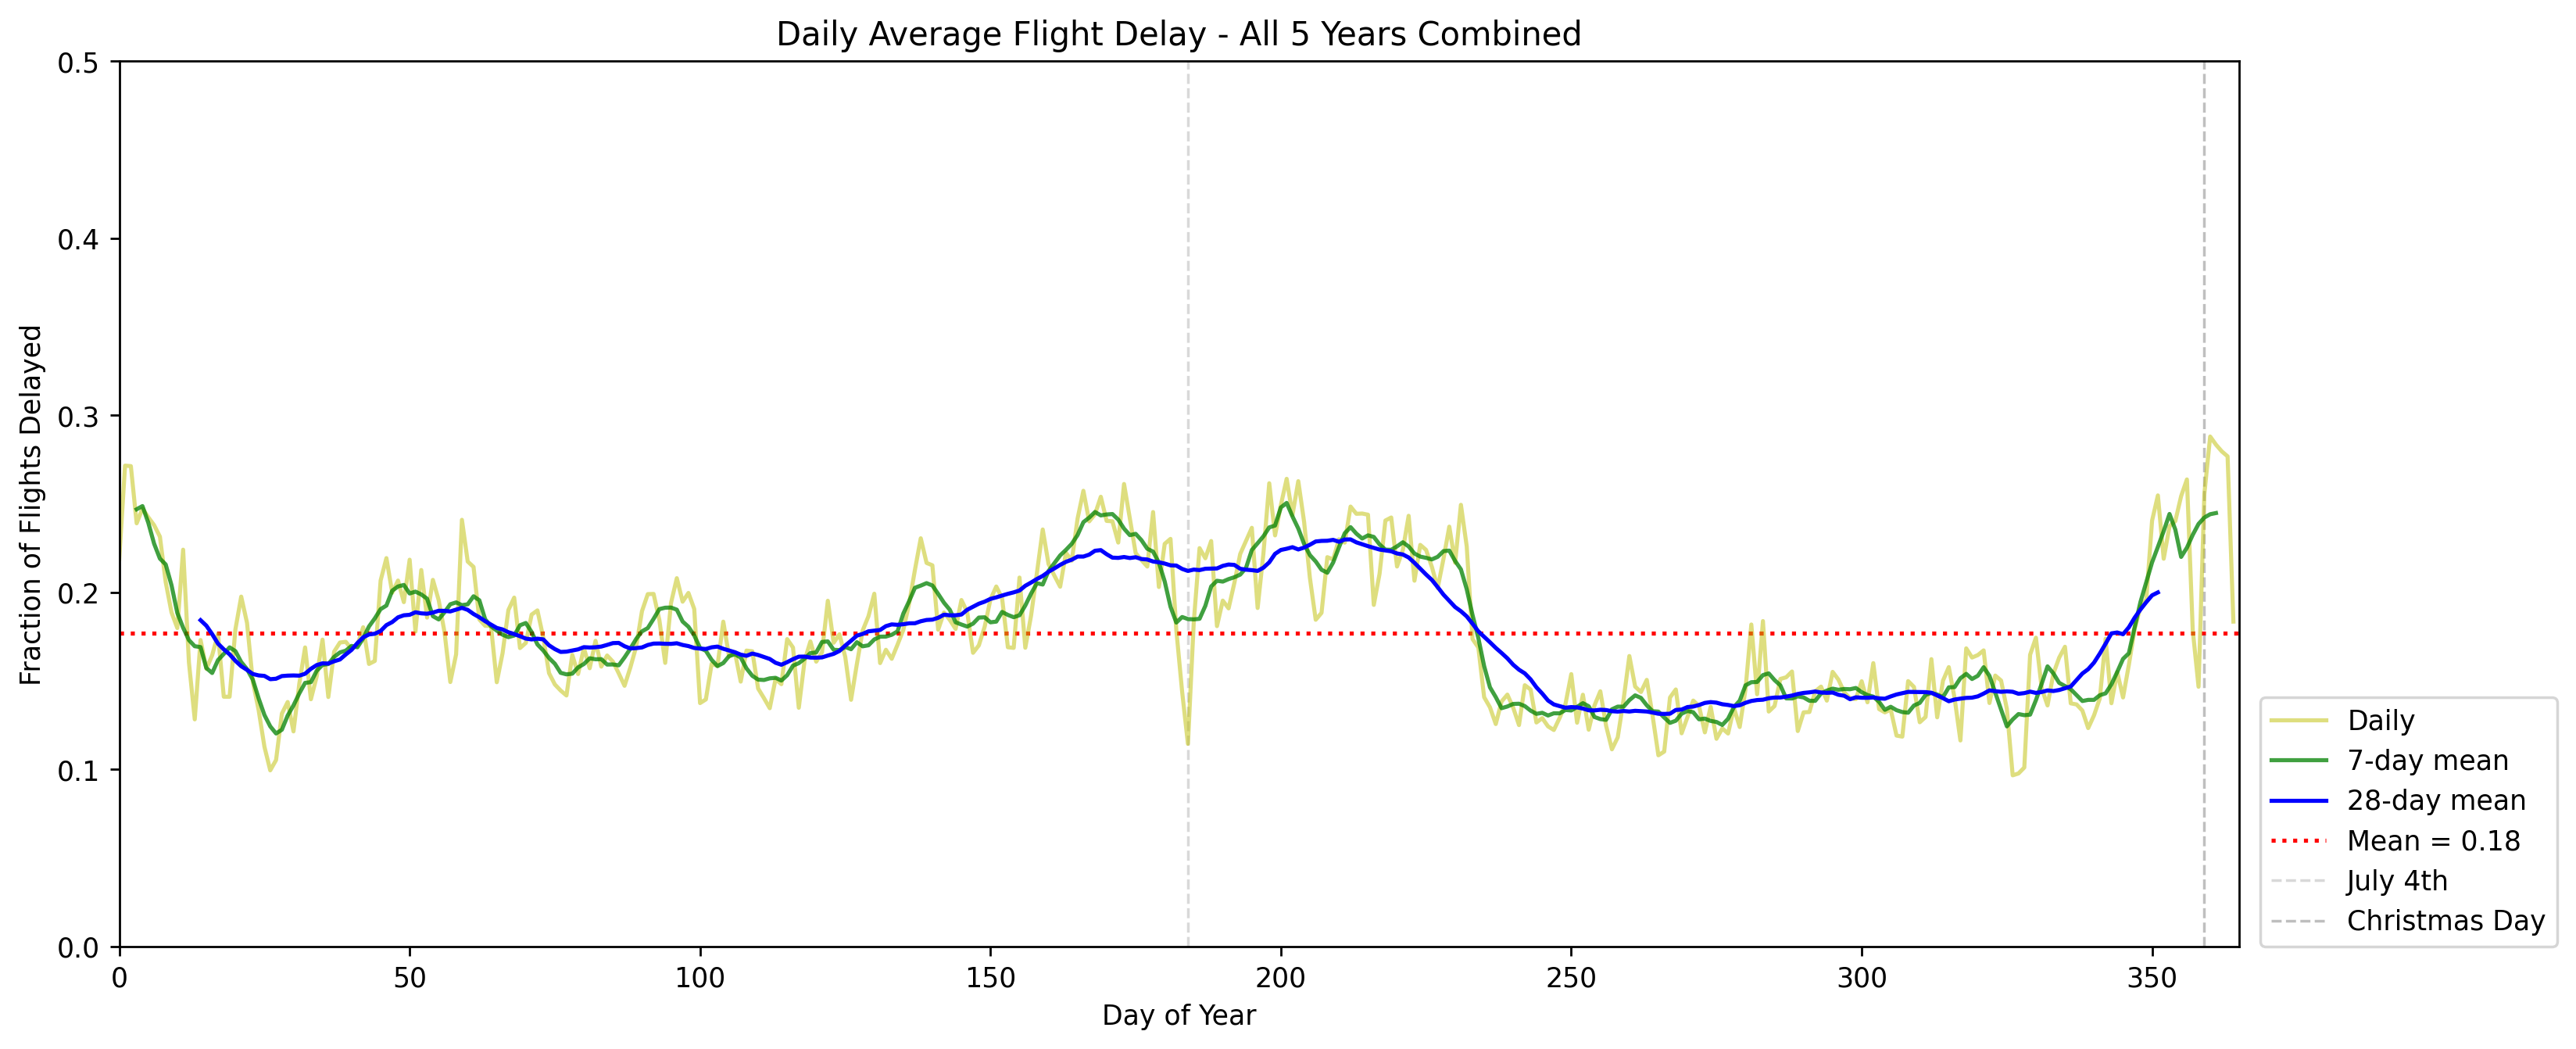

(0.0, 365.0)

In [0]:
# Create the single average plot:
fig, ax = plt.subplots(figsize=(14, 6), dpi=250)

# Plot averages first:
mu = pd.Series(np.mean([v.values for v in delay_date_by_year.values()], axis=0))
ax.set_title("Daily Average Flight Delay - All 5 Years Combined")
ax.plot(mu.values, label="Daily", alpha=0.5, color="y")
rolling_week = mu.rolling(7, center=True).mean()
ax.plot(rolling_week, label="7-day mean", alpha=0.75, color="g")
rolling_week = mu.rolling(28, center=True).mean()
ax.plot(rolling_week, label="28-day mean", alpha=1, color="b")

# Mean:
total_mean = mu.mean()
ax.hlines(total_mean, 0, 365, label=f"Mean = {total_mean:.2f}", color="r", linestyle=":")

# Holidays:
ax.vlines(184, 0, 0.5, label="July 4th", color="#b3b3b3", 
          linestyle="--", lw=1, alpha=0.5)
ax.vlines(359, 0, 0.5, label="Christmas Day", 
          color="#808080", linestyle="--", lw=1, alpha=0.5)

# Labels:
ax.legend(loc=(1.01, 0))
ax.set_ylabel("Fraction of Flights Delayed")
ax.set_xlabel("Day of Year")
# ax.set_xticklabels([])
# ax.set_xticks([])
ax.set_ylim(0, 0.5)
ax.set_xlim(0, 365)

### 5. Airline Carrier Factor

We found that the number of delays is associated with airline carriers and ranked the top 10 airline carriers by the most number of delays (see below for Top 5):

1. Southwest Airlines (WN) 
2. American Airlines (AA)
3. Delta Airlines (DL)
4. SkyWest Airlines (OO)
5. United Airlines (UA)

Therefore, we will include the carrier feature `OP_CARRIER` for feature selection.

In [0]:
# Explore Top 10 Most popular Origin Airports
num_dep_delay = df_airlines.select( 'ORIGIN','DEP_DEL15' ).groupBy('ORIGIN').agg(f.sum('DEP_DEL15')).withColumnRenamed('sum(DEP_DEL15)', 'Num_Departure_Delay') 
df = num_dep_delay.toPandas()
df1_sort = df.sort_values(by='Num_Departure_Delay', ascending=False)
origin_airport_top10 = df1_sort.head(10)

# Explore Top 10 Most popular Destination Airports
num_dep_delay = df_airlines.select( 'DEST','DEP_DEL15' ).groupBy('DEST').agg(f.sum('DEP_DEL15')).withColumnRenamed('sum(DEP_DEL15)', 'Num_Departure_Delay') 
df = num_dep_delay.toPandas()
df2_sort = df.sort_values(by='Num_Departure_Delay', ascending=False)
dest_airport_top10 = df2_sort.head(10)

# Explore Top 10 Airline Carrier patterns
num_dep_delay = df_airlines.select( 'OP_UNIQUE_CARRIER','DEP_DEL15' ).groupBy('OP_UNIQUE_CARRIER').agg(f.sum('DEP_DEL15')).withColumnRenamed('sum(DEP_DEL15)', 'Num_Departure_Delay') 
df = num_dep_delay.toPandas()
df_sort = df.sort_values(by='Num_Departure_Delay', ascending=False)
airline_carrier = df_sort.head(10)

Out[75]:

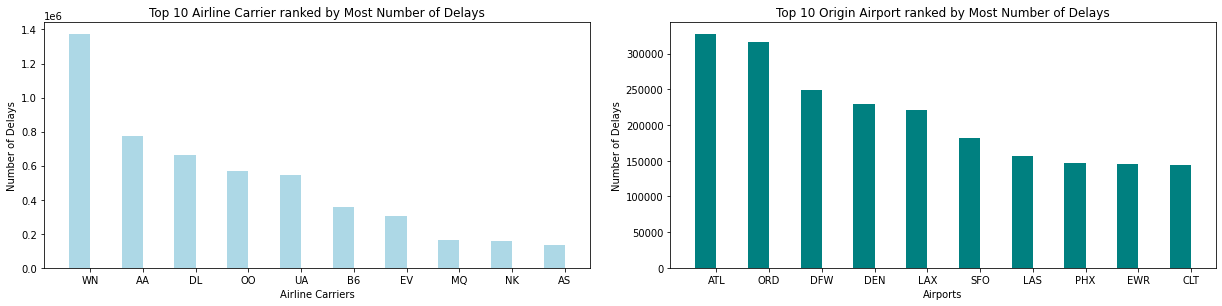

[Text(0.2, 0, 'ATL'),
 Text(1.2, 0, 'ORD'),
 Text(2.2, 0, 'DFW'),
 Text(3.2, 0, 'DEN'),
 Text(4.2, 0, 'LAX'),
 Text(5.2, 0, 'SFO'),
 Text(6.2, 0, 'LAS'),
 Text(7.2, 0, 'PHX'),
 Text(8.2, 0, 'EWR'),
 Text(9.2, 0, 'CLT')]

In [0]:
# Draw histograms for Top 10 Origin Airports, Top 10 Destination Airports and the Airline Carriers depicting departure delays
fig, ax = plt.subplots(1,2, figsize = (17, 4))
fig.tight_layout(h_pad=15, w_pad=5) 

# Airline Carrier
x = np.arange(len(airline_carrier['OP_UNIQUE_CARRIER'].unique()))
bar_width = 0.4

# Add `width` parameter now which sets the width of each bar.
hist1 = ax[0].bar(x, airline_carrier['Num_Departure_Delay'],
            width=bar_width, label='Num_Departure_Delay', color='lightblue')

ax[0].set_ylabel("Number of Delays")
ax[0].set_xlabel("Airline Carriers")
ax[0].set_title("Top 10 Airline Carrier ranked by Most Number of Delays")
ax[0].set_xticks(x + bar_width / 2)
ax[0].set_xticklabels(airline_carrier['OP_UNIQUE_CARRIER'].unique())

# Origin Airports
x = np.arange(len(origin_airport_top10['ORIGIN'].unique()))
bar_width = 0.4

hist2 = ax[1].bar(x, origin_airport_top10['Num_Departure_Delay'],
            width=bar_width, label='Num_Departure_Delay', color='Teal')
 
ax[1].set_ylabel("Number of Delays")
ax[1].set_xlabel("Airports")
ax[1].set_title("Top 10 Origin Airport ranked by Most Number of Delays")
ax[1].set_xticks(x + bar_width / 2)
ax[1].set_xticklabels(origin_airport_top10['ORIGIN'].unique())

### 6. Origin Airport Factor

The Top 5 airports with most number of delays are ATL, ORD, DFW, DEN and LAX. This is intuitive because these are the busiest connection hubs in the U.S. and have the most traffic. The scatter plot of airports below shows the relationship between the busyness of an airport and the proportion of its flights which are delayed. Overall there appears to be a very slight increasing linear relationship, but we also see significant variance which makes it likely that including the origin airport in feature selection will be useful for predicting flight delays. We incorporate the Average Delay by airport prior to flight departure in the feature engineering section.

/databricks/python/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
 result = getattr(ufunc, method)(*inputs, **kwargs)

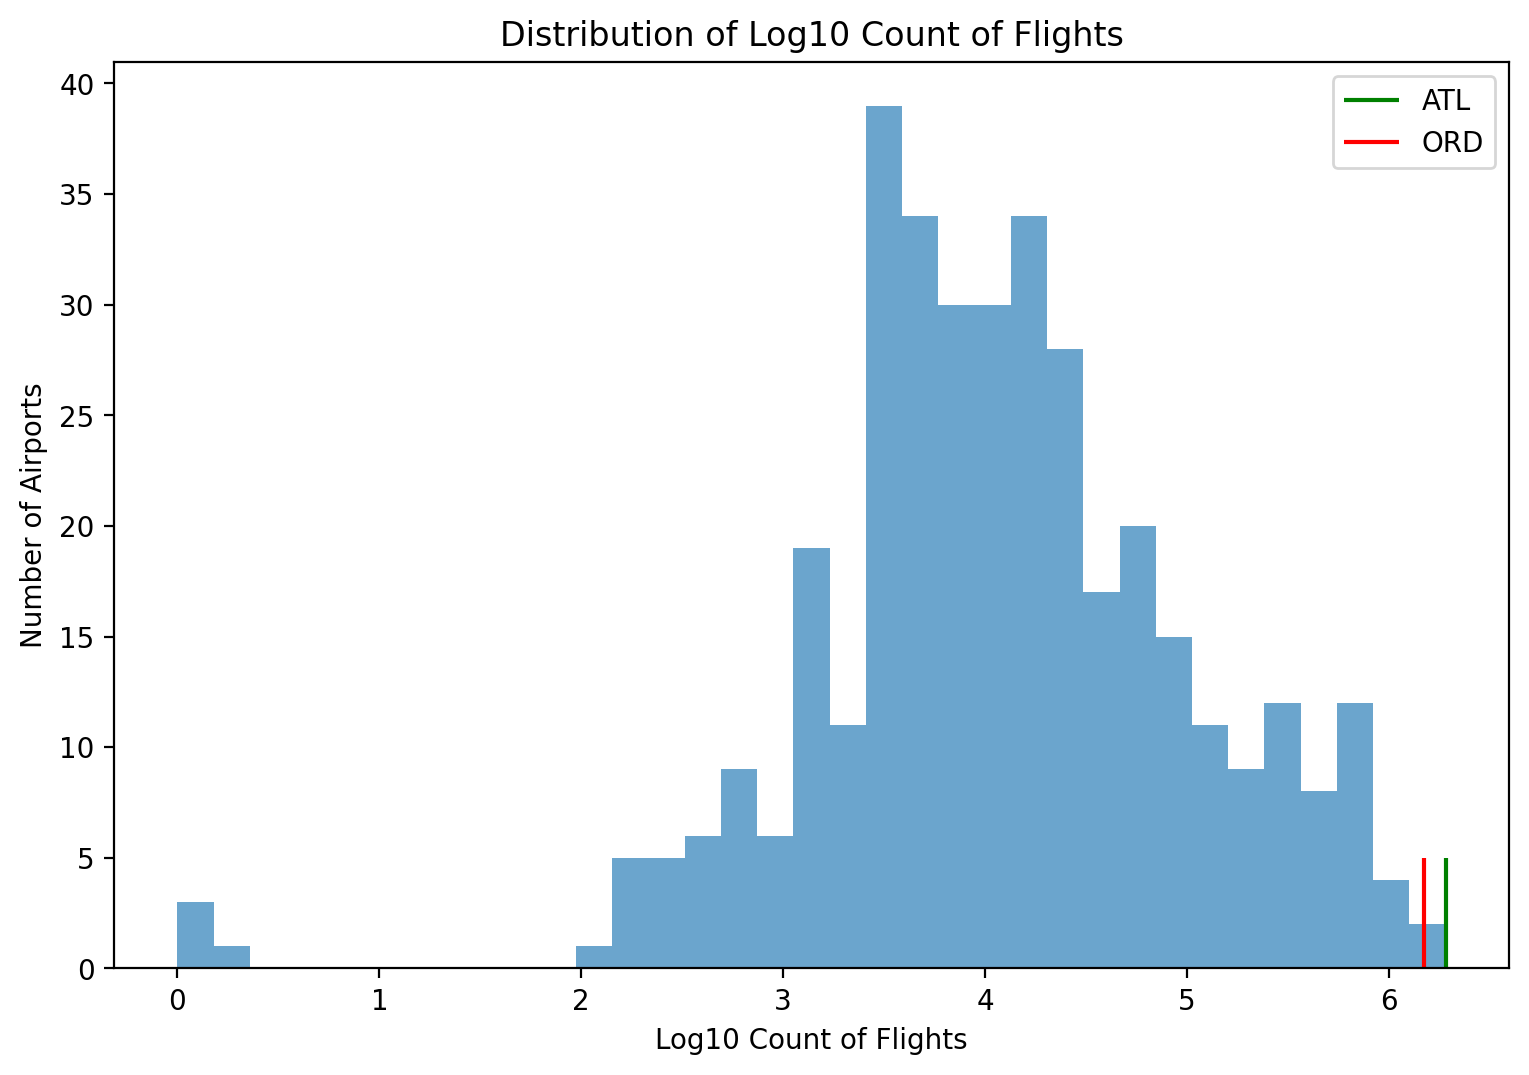

In [0]:
# Get the count of flights by airport:
origin_count = df_airlines.groupby("ORIGIN").count().toPandas()
dest_count = df_airlines.groupby("DEST").count().toPandas()

flight_counts = pd.merge(
  origin_count.rename(columns={"count": "origin_count"}), 
  dest_count.rename(columns={"count": "dest_count"}),
  left_on="ORIGIN", 
  right_on="DEST", 
  how="outer"
).sort_values(by=["origin_count", "dest_count"], ascending=False)
flight_counts["origin_count"] = flight_counts["origin_count"].fillna(0).astype(int)
flight_counts["dest_count"] = flight_counts["dest_count"].fillna(0).astype(int)

# Merge in the count of delayed flights by airport:
origin_delay_count = df_airlines.groupby("ORIGIN").sum("DEP_DEL15").toPandas()
origin_delay_count = origin_delay_count.rename(columns={"sum(DEP_DEL15)": "num_delays"})
flight_counts = pd.merge(flight_counts, origin_delay_count, on="ORIGIN", how="left")
flight_counts["num_delays"] = flight_counts["num_delays"].fillna(0).astype(int)
flight_counts["proportion_delayed"] = flight_counts["num_delays"] / flight_counts["origin_count"]

# Add log-10 of number of flights for plotting:
flight_counts["log_10_origin_count"] = np.log(flight_counts["origin_count"]) / np.log(10)

# Drop airports which were only destinations:
flight_counts = flight_counts[flight_counts["origin_count"] > 0]

# Data series for Atlanta and Chicago airports:
atl = flight_counts.set_index("ORIGIN").loc["ATL"]
ord = flight_counts.set_index("ORIGIN").loc["ORD"]

# Histogram of log-10 number of flights by airport:
fig, ax = plt.subplots(figsize=(9, 6), dpi=200)
ax.hist(flight_counts["log_10_origin_count"], bins=35, alpha=.66)
ax.set_ylabel(f"Number of Airports")
ax.set_xlabel("Log10 Count of Flights")
ax.vlines(atl["log_10_origin_count"], 0, 5, color="g", label="ATL")
ax.vlines(ord["log_10_origin_count"], 0, 5, color="r", label="ORD")
ax.legend()
ax.set_title("Distribution of Log10 Count of Flights")
plt.show()

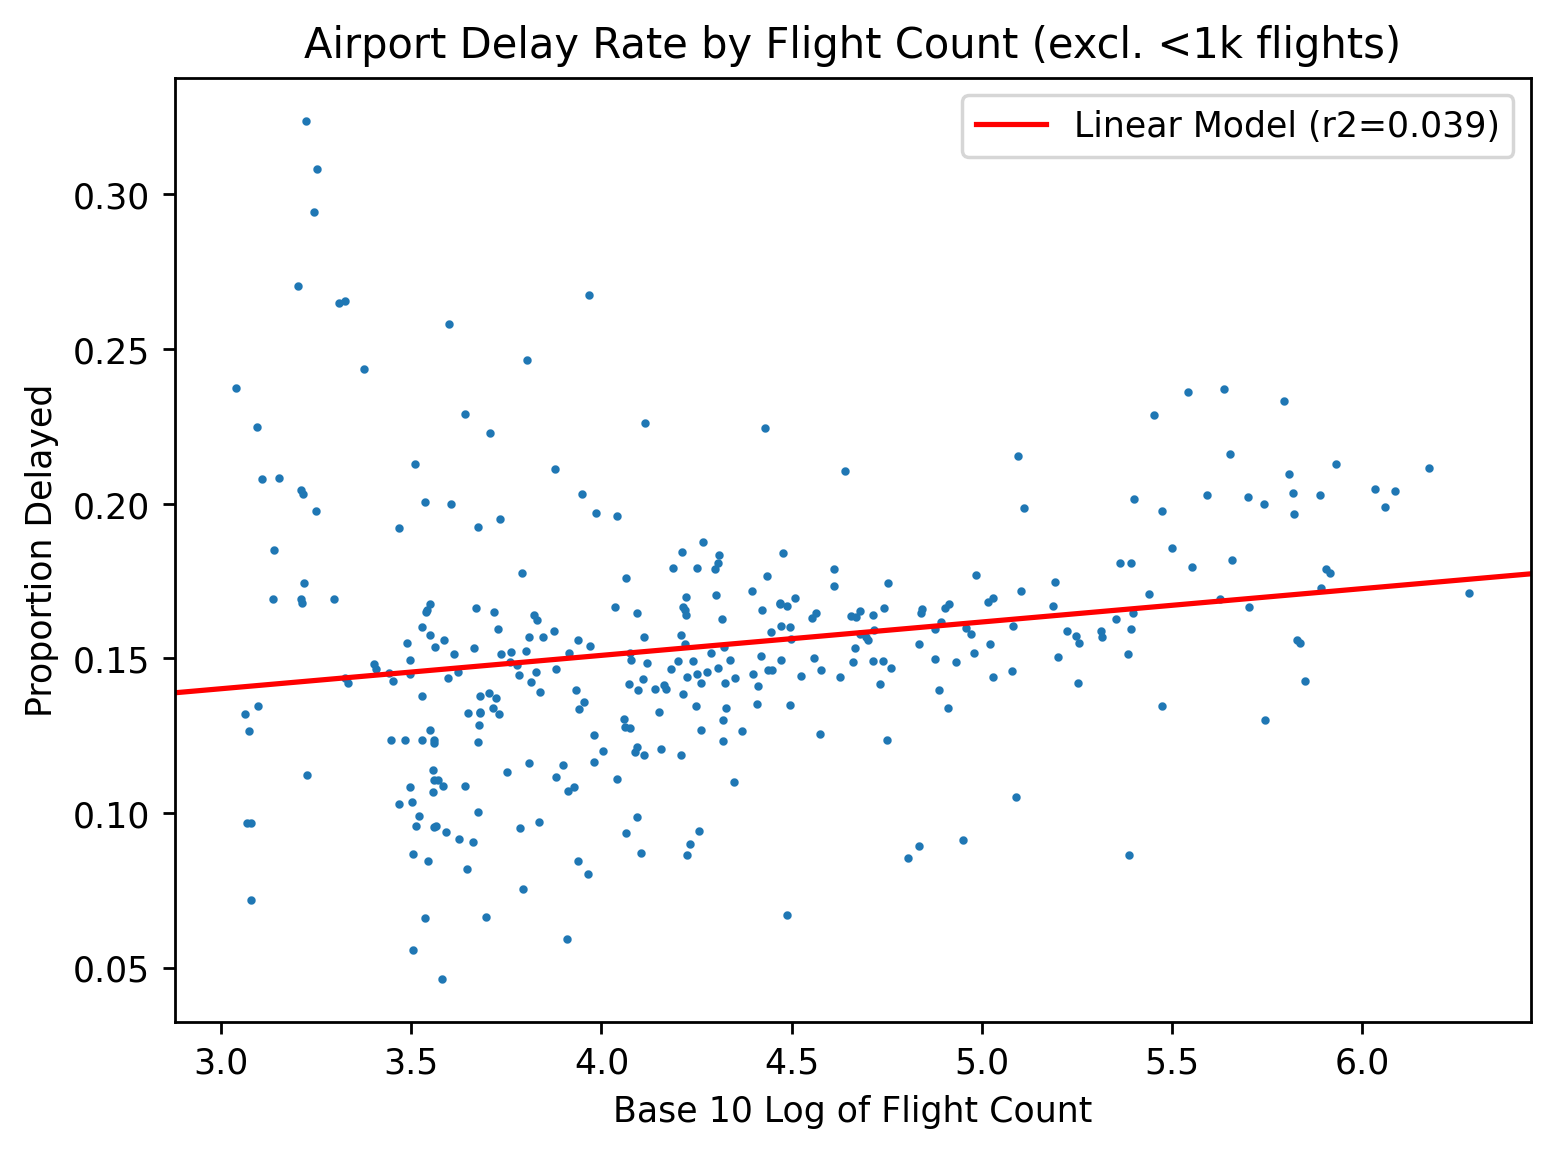

In [0]:
# Bar chart of log-10 number of flights by airport:
subset = flight_counts[flight_counts["origin_count"] > 1000]
fig, ax = plt.subplots(figsize=(7, 5), dpi=250)
ax.scatter(subset["log_10_origin_count"], subset["proportion_delayed"], s=2)
ax.set_xlabel(f"Base 10 Log of Flight Count")
ax.set_ylabel("Proportion Delayed")

# Fit a model and plot the line:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(subset[["log_10_origin_count"]], subset["proportion_delayed"])
r2 = model.score(subset[["log_10_origin_count"]], subset["proportion_delayed"])
x_min, x_max = ax.get_xlim()
y_min = model.coef_[0] * x_min + model.intercept_
y_max = model.coef_[0] * x_max + model.intercept_
ax.plot([x_min, x_max],  [y_min, y_max], color="r", label=f"Linear Model (r2={r2:.3f})")
ax.set_xlim(x_min, x_max)
ax.legend()
ax.set_title("Airport Delay Rate by Flight Count (excl. <1k flights)")
plt.show()

Daily Average Flight Delay (5 Years)

* Outcome variable in the flights table is a binary variable indicating whether or not the flight departure was delayed by 15 minutes or more. 
* Obviously the difficulty of the task is that there are many factors that can contribute to flights delays - including weather, staffing issues at the airports or the airlines, technical problems, etc. This chart is showing that there is a seasonal component to the delays.
Red dotted line = mean average across all years; approximately 18% of flights are delayed
Vertical dotted lines show big holidays July 4th and Christmas. Noticeable that delays on the holidays are lower probably because fewer people travel, but there are peaks either side when there is a busy period of traveling.
Yellow line shows daily average, lots of variance making the task of prediction challenging, even when averaged over 5 years of data as in this chart.
Noticeable peaks in delays around winter - possibly due to busier airports and adverse weather. And in summer, probably more due to busier airports.

# Weather Dataset EDA

In [0]:
# Load the full weather dataset
weather = spark.read.option("header", "true").parquet("/mnt/mids-w261/datasets_final_project/weather_data/*.parquet")
# display(weather)

In [0]:
# Summary of weather data
display(weather.describe())

In [0]:
# Check for weather data duplicates

print("Total records count without dropping duplicates:", weather.count())

df_airlines = weather.dropDuplicates()

print("Total records count after dropping duplicates:", weather.count())

Total records count without dropping duplicates: 630904436
Total records count after dropping duplicates: 630904436

In [0]:
# Number of Unique Weather Stations
# display(weather.select("STATION").distinct())
print("Total Number of Unique Stations:", weather.select("STATION").distinct().count())

Total Number of Unique Stations: 15195

In [0]:
#The min and max date of the weather table
min_date_weather =weather.select(f.min(f.col("DATE")).alias("MIN")).limit(1).collect()[0].MIN
max_date_weather =weather.select(f.max(f.col("DATE")).alias("MAX")).limit(1).collect()[0].MAX
print(f"Earliest date in weather table is: {min_date_weather}")
print(f"Latest date in weather table is: {max_date_weather}")

Earliest date in weather table is: 2015-01-01 00:00:00
Latest date in weather table is: 2019-12-31 23:59:00

### 1. High-level overview

The raw weather dataset contains a total records count of 630,904,436 rows. Several key properties of the dataset are listed below:

|Property|Data|
|-----------|----|
|Total row count| 630,904,436|
|Total columns/features count|175|
|Earliest weather time | 2015-01-01 00:00:00|
|Latest weather time|2019-12-31 23:59:00|
|Number of Unique Weather Stations|15,195|

### 2. EDA on counts of Null and sparse fields
We looked at the completeness of the weather data set to identify the columns that are relevant by looking at the coverage of the data (completeness) across the different variables. (Chart below)

In [0]:
null_count={}
for field in weather.columns:
  null_count[field]=weather.select(field).where(f.col(field)=='').count()
  

In [0]:
percent_coverage  = (100 - 100* pd.DataFrame([null_count])/weather.count())

Displaying the sparsity of most Weather features

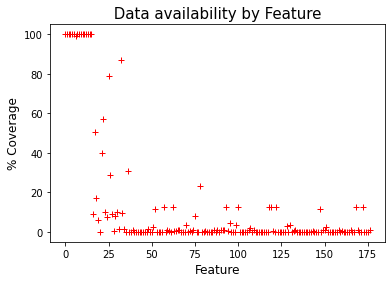

In [0]:
p=percent_coverage.T.values
plt.plot(p,'r+')
plt.title(' Data availability by Feature ',fontsize=15)
plt.xlabel('Feature',fontsize=12)
plt.ylabel('% Coverage', fontsize=12)
plt.rcParams["figure.figsize"] = [18,6]

In [0]:
## Filter for non Sparse fields
non_sparse = percent_coverage.T.reset_index().rename_axis(None).rename_axis(None, axis=1)
non_sparse = non_sparse.rename(columns = {'index':'Field'})
non_sparse.rename( columns={0 :'Coverage'}, inplace=True )
non_sparse[non_sparse.Coverage>90]

Out[114]:

,Field,Coverage
0,STATION,100.000000
1,DATE,100.000000
2,SOURCE,100.000000
3,LATITUDE,100.000000
4,LONGITUDE,100.000000
5,ELEVATION,100.000000
6,NAME,99.252577
7,REPORT_TYPE,100.000000
8,CALL_SIGN,100.000000
9,QUALITY_CONTROL,100.000000


Most of the fields are Null

In [0]:
fields=['STATION','DATE','LATITUDE','LONGITUDE','ELEVATION','NAME','WIND','TMP','DEW','SLP']
weather_imp= weather.select('STATION','DATE','LATITUDE','LONGITUDE','ELEVATION','NAME', f.split('WND', ',').alias('WND'), f.split('VIS', ',').alias('VIS'), f.split('TMP', ',').alias('TMP'), f.split('DEW', ',').alias('DEW'), f.split('SLP', ',').alias('SLP'))
 

weather_imp = weather_imp.select('STATION','DATE','LATITUDE','LONGITUDE','ELEVATION','NAME', *[weather_imp['WND'][i] for i in range(5)], *[weather_imp['VIS'][i] for i in range(4)], *[weather_imp['TMP'][i] for i in range(2)], *[weather_imp['DEW'][i] for i in range(2)], *[weather_imp['SLP'][i] for i in range(2)])
# rename extracted columns
column_rename = ['STATION','DATE','LATITUDE','LONGITUDE','ELEVATION','NAME', 'WND_dir', 'WND_dir_qlty', 'WND_type', 'WND_spd', 'WND_spd_qlty', 'VIS_dim', 'VIS_dim_qlty', 'VIS_var', 'VIS_var_qlty', 'TMP_air', 'TMP_air_qlty', 'DEW_tmp', 'DEW_tmp_qlty', 'SLP_air', 'SLP_air_qlty']
weather_imp = weather_imp.toDF(*column_rename)
# convert numerical fields to int

for col in ['WND_dir', 'WND_spd',  'VIS_dim', 'TMP_air', 'DEW_tmp', 'SLP_air']:
    weather_imp = weather_imp.withColumn(col, f.col(col).cast(IntegerType()))

In [0]:
# display(weather_imp)

# EDA on Joined Dataset
Please refer to Full Data Pipeline Notebook for details about how to clean data and join tables using external dataset. After joining the full dataset, we stored the full dataset with features into Azure Blob storage and read the data below.

In [0]:
final_df = spark.read.parquet(f"{blob_url}/full_dataset_full_features_v2")

We attempted to create scatterplots to explore the relationship between the target variable `DEP_DELAY` and other weather and flight related features. But the challenge is each data point represents one flight trip in the scatterplot and each plot's distribution will be skewed towards the range with highest occurrence groups. Therefore we can not draw conclusions from the scatterplot distribution without aggregating the mean of departure delay `DEP_DELAY`.

As an example, we decided to plot a histogram of Average Delay by Flight Distance Group which aggregates the average departure delay (in minutes) by Distance Group with 250 miles intervals. The histogram shows a close to uniform distribution between average departure delay and Flight Distance, with most of the flights in group 2 (n = 7,458,077). It seems middle distance flights (group 5) are slightly more delayed with an average of 11 minutes.

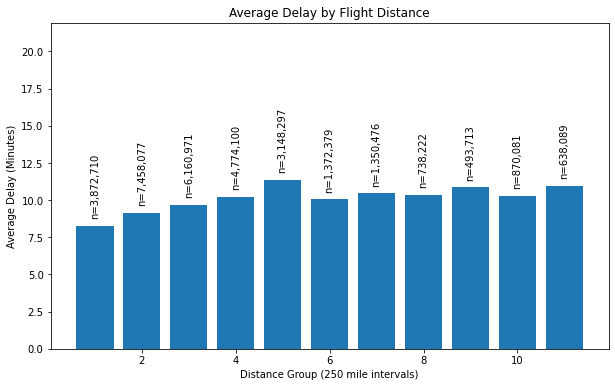

In [0]:
# Delay by Flight Distance
distance_delay = final_df.select("DISTANCE_GROUP", "DEP_DELAY")\
                           .groupby("DISTANCE_GROUP")\
                           .agg(mean("DEP_DELAY"), count("DEP_DELAY"))\
                           .sort("DISTANCE_GROUP")\
                           .collect()
distance_df = pd.DataFrame(distance_delay, columns=["DISTANCE_GROUP", "AVG_DELAY", "N"])
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(distance_df["DISTANCE_GROUP"], height=distance_df["AVG_DELAY"])
ax.set_xlabel("Distance Group (250 mile intervals)")
ax.set_ylabel("Average Delay (Minutes)")
ax.set_title("Average Delay by Flight Distance")
for i, row in distance_df.iterrows():
  group, delay, n = row["DISTANCE_GROUP"], row["AVG_DELAY"]+0.5, f"n={row['N']:,.0f}"
  ax.text(group, delay, n, ha="center", va="bottom", rotation=90)
ax.set_ylim(0, ax.get_ylim()[1]+10)
plt.show()

### Correlation Matrix
After joining the weather, station and airlines dataset, we separated weather related variables by Origin and Destination airport. Then we generated a correlation matrix for weather numeric variables in relation to the DEP_DELAY which is the difference in minutes between scheduled and actual departure time, since Pearson correlation is not suitable for more than two categorical variables.

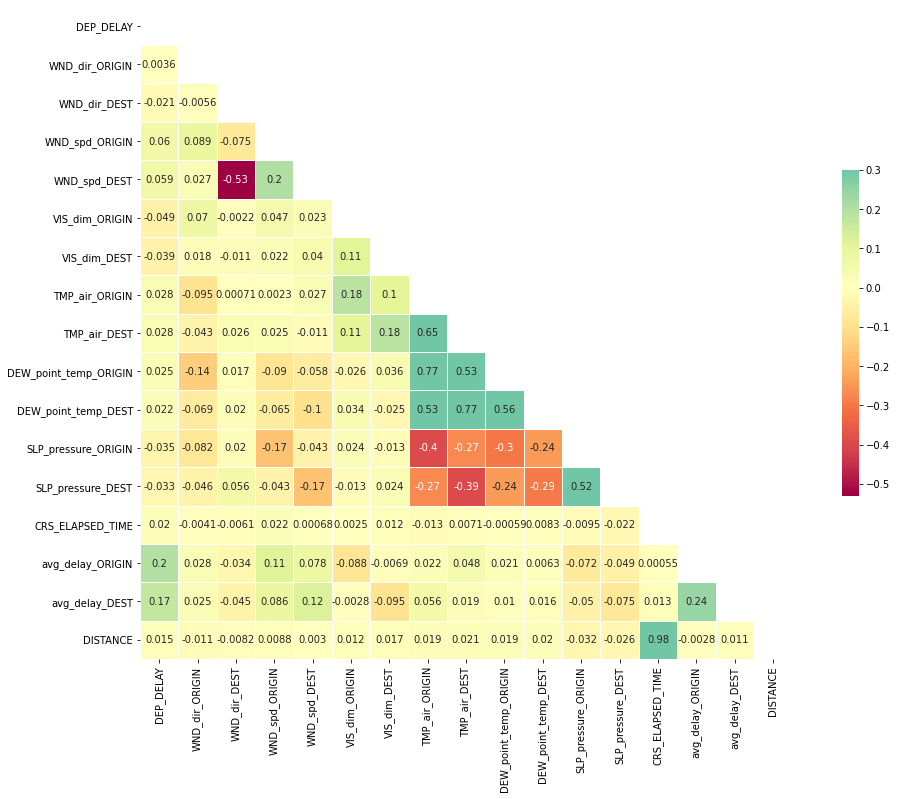

In [0]:
import seaborn as sns

data = final_df
corr_matrix = data.select(['DEP_DELAY',
'WND_dir_ORIGIN', 'WND_dir_DEST', # Wind direction (Weather)
    'WND_spd_ORIGIN', 'WND_spd_DEST', # Wind speed (Weather)
    'VIS_dim_ORIGIN', 'VIS_dim_DEST', # Visibility distance (Weather)
    'TMP_air_ORIGIN', 'TMP_air_DEST', # Air temperature (Weather)
    'DEW_point_temp_ORIGIN', 'DEW_point_temp_DEST', # Dew point temperature (Weather)
    'SLP_pressure_ORIGIN', 'SLP_pressure_DEST', # Sea level pressure (Weather)
    'CRS_ELAPSED_TIME', # Scheduled airtime (Flight)
    'avg_delay_ORIGIN', 'avg_delay_DEST', # Average delay (minutes) 2-6 hours (New feature)
    'DISTANCE' # Distance between origin and destination
                          ])
df_airlines_corr = corr_matrix.select("*").toPandas()

plt.figure(figsize=(23,10))
corr = df_airlines_corr.corr() 

# Matplotlib
fig, ax = plt.subplots(figsize=(18, 12))

# Colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap='Spectral'

# Heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()